# Simulate dephased Rabi oscillations with the Schrodinger equation

In [1]:
from numpy import *
from numpy.random import normal
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Detuning pulled from normal distribution for each Schrodinger solution
This assumes that each time we evolve the state, there is a different detuning of the field. The average of several such solutions shows a dephased Rabi oscillation. This is not quite the situation in the lab, since we do not evolve the state over the entire time range of interest for each measurement.

In [2]:
psi0 = array([1,0], complex) # population starts in |0>

o = 2*pi # the rabi frequency

# mean and standard dev. of detuning relative to Rabi frequency
# the detuning in the lab can drift, e.g., due to incosistent AC Stark shifts, magnetic field noise, etc
d_mean = 0*o
d_std_arr = array([0.05,0.1,0.5,1,5])*o

numsteps = 25
tmin = 0
tmax = 3*2*pi/(o)

averages = 100 

times = linspace(tmin,tmax,100)
avg_P0 = zeros((len(d_std_arr),len(times))) # average probability of measuring P(0)

for i,d_std in enumerate(d_std_arr):
    for avg in range(averages):
    
        d = normal(loc=d_mean, scale=d_std)
        # atom+field Hamiltonian, hbar=1
        Haf = lambda t: array([[d/2,-o/2],[-o/2,0]])
        dpsi = lambda t,state: -1j*dot(Haf(t),state) # LHS of Schrodinger eq
        
        soln = solve_ivp(dpsi,t_span=[tmin,tmax],t_eval=times,y0=psi0,vectorized=True)
        avg_P0[i] += abs(soln.y[0])**2
avg_P0 /= averages
print("simulation done!")

simulation done!


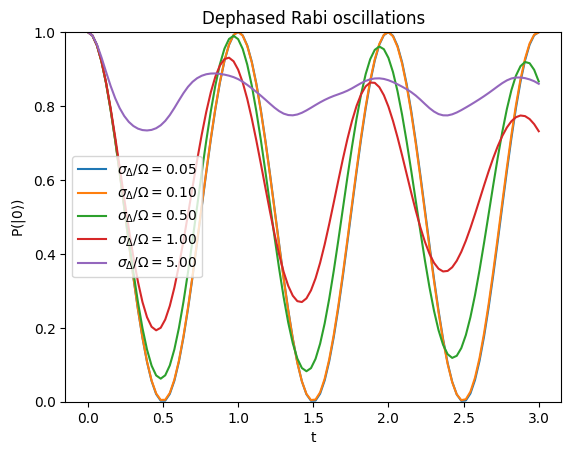

In [3]:
for i in range(len(d_std_arr)):
    plt.plot(soln.t,avg_P0[i],label=r'$\sigma_{\Delta}/\Omega=$'+f'{d_std_arr[i]/o:.2f}')
plt.title("Dephased Rabi oscillations")
plt.legend()
plt.ylim((0,1))
plt.xlabel("t")
plt.ylabel(r"P($|0\rangle$)")
plt.show()

## Detuning determined by random walk over experiment durations
This might more closely match what happens in the lab. Several measurements are made for a particular evolution time, then the result is averaged to get one data point. This is one iteration. If the detuning is doing a random walk over time, then the evolution may proceed as expected for earlier iterations as the detuning has not walked far. But over time, it makes significant progress in walking away from being resonant with the field.

### compare different amounts of detuning drift

In [11]:
psi0 = array([1,0], complex) # population starts in |0>

o = 2*pi # the rabi frequency

# using the same language as in the lab
measurements = 50 # each measurement corresponds to evolving the state up to a certain time
iterations = 20 # each iteration is a set of measurements a given timestep

d_std_arr = array([0, 1, 2, 5, 10])*o # standard deviations of the detuning over the experiment run

numsteps = 25
tmin = 0
tmax = 3*2*pi/(o)

times = linspace(tmin,tmax,iterations)
avg_P0 = zeros((len(d_std_arr), len(times))) # average probability of measuring P(0)
avg_P0[:, 0]=1 # no evolution

for j,d_sigma in enumerate(d_std_arr): # do the simulation for different std of the detuning random walk

    # Generate detunings according to a random walk centered around 0
    step_size = d_sigma/sqrt(iterations*measurements)
    steps = random.choice([-step_size, step_size], size=iterations*measurements)
    detunings = cumsum(steps) # array of positions after each step
    detunings = insert(detunings, 0, 0) # Insert the starting point (0) at the beginning of the position array
    
    for i in range(1,iterations):
        t = times[i]
        for measurement in range(measurements):
            
            d = detunings[i*measurements + measurement]
            
            # atom+field Hamiltonian, hbar=1
            Haf = lambda t: array([[d/2,-o/2],[-o/2,0]])
            dpsi = lambda t,state: -1j*dot(Haf(t),state) # LHS of Schrodinger eq
            
            soln = solve_ivp(dpsi,t_span=[tmin,t],y0=psi0,vectorized=True)
            avg_P0[j,i] += abs(soln.y[0,-1])**2 # get the last point of the evolution
    avg_P0[j,1:] /= measurements
    print(f"simulation {j} done!")

simulation 0 done!
simulation 1 done!
simulation 2 done!
simulation 3 done!
simulation 4 done!


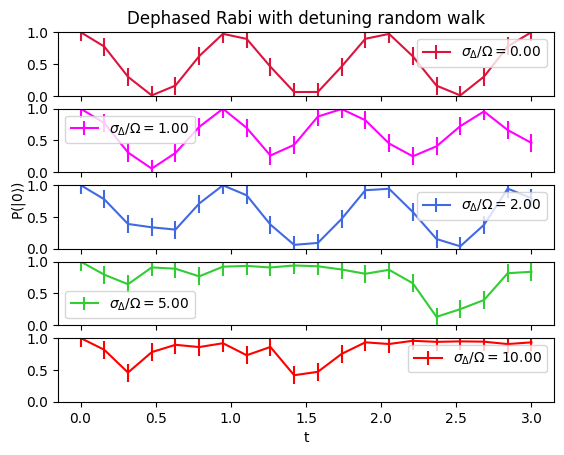

In [12]:
fig,axes = plt.subplots(nrows = len(d_std_arr), sharex=True)
colors = ['crimson', 'magenta', 'royalblue','limegreen', 'red', 'cyan', 'orange']
for j,d_sigma in enumerate(d_std_arr):
    ax = axes[j]
    ax.errorbar(times, avg_P0[j,:], 1/sqrt(measurements),label=r'$\sigma_{\Delta}/\Omega=$'+f'{d_sigma/o:.2f}',c=colors[j])
    ax.set_ylim((0,1))
    ax.legend()
axes[0].set_title("Dephased Rabi with detuning random walk")
ax.set_xlabel("t")
fig.text(0.05,0.5,r"P($|0\rangle$)",rotation='vertical')
plt.show()

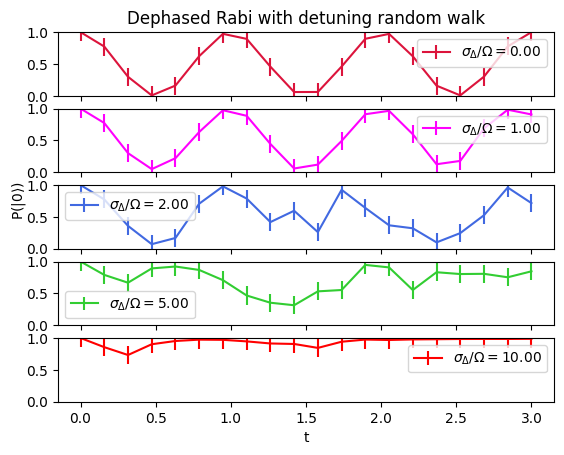

In [10]:
fig,axes = plt.subplots(nrows = len(d_std_arr), sharex=True)
colors = ['crimson', 'magenta', 'royalblue','limegreen', 'red', 'cyan', 'orange']
for j,d_sigma in enumerate(d_std_arr):
    ax = axes[j]
    ax.errorbar(times, avg_P0[j,:], 1/sqrt(measurements),label=r'$\sigma_{\Delta}/\Omega=$'+f'{d_sigma/o:.2f}',c=colors[j])
    ax.set_ylim((0,1))
    ax.legend()
axes[0].set_title("Dephased Rabi with detuning random walk")
ax.set_xlabel("t")
fig.text(0.05,0.5,r"P($|0\rangle$)",rotation='vertical')
plt.show()

### compare different experiment runs with the same detuning drift
With the same $\sigma_\Delta$, how do different runs compare?

In [25]:
psi0 = array([1,0], complex) # population starts in |0>

o = 2*pi # the rabi frequency

# using the same language as in the lab
measurements = 50 # each measurement corresponds to evolving the state up to a certain time
iterations = 20 # each iteration is a set of measurements a given timestep

d_sigma = 5*o # standard deviations of the detuning over the experiment run

numsteps = 25
tmin = 0
tmax = 3*2*pi/(o)

experiment_runs = 5

times = linspace(tmin,tmax,iterations)
avg_P0 = zeros((experiment_runs, len(times))) # average probability of measuring P(0)
avg_P0[:, 0]=1 # no evolution

for j in range(experiment_runs): # do the simulation for different std of the detuning random walk

    # Generate detunings according to a random walk centered around 0
    step_size = d_sigma/sqrt(iterations*measurements)
    steps = random.choice([-step_size, step_size], size=iterations*measurements)
    detunings = cumsum(steps) # array of positions after each step
    detunings = insert(detunings, 0, 0) # Insert the starting point (0) at the beginning of the position array
    
    for i in range(1,iterations):
        t = times[i]
        for measurement in range(measurements):
            
            d = detunings[i*measurements + measurement]
            
            # atom+field Hamiltonian, hbar=1
            Haf = lambda t: array([[d/2,-o/2],[-o/2,0]])
            dpsi = lambda t,state: -1j*dot(Haf(t),state) # LHS of Schrodinger eq
            
            soln = solve_ivp(dpsi,t_span=[tmin,t],y0=psi0,vectorized=True)
            avg_P0[j,i] += abs(soln.y[0,-1])**2 # get the last point of the evolution
    avg_P0[j,1:] /= measurements
    print(f"simulation {j} done!")

simulation 0 done!
simulation 1 done!
simulation 2 done!
simulation 3 done!
simulation 4 done!


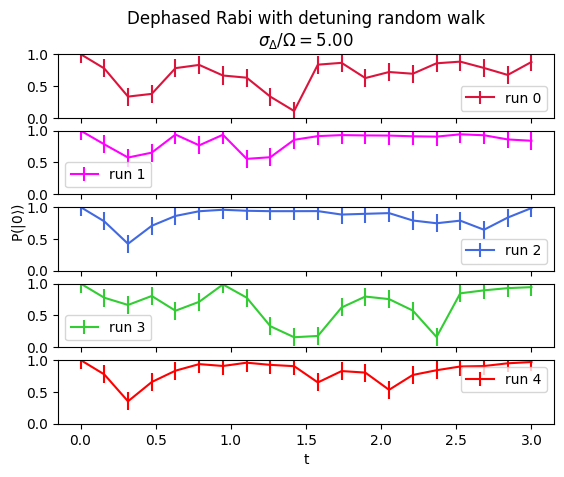

In [30]:
fig,axes = plt.subplots(nrows=experiment_runs, sharex=True)
colors = ['crimson', 'magenta', 'royalblue','limegreen', 'red', 'cyan', 'orange']
for j in range(experiment_runs):
    ax = axes[j]
    ax.errorbar(times, avg_P0[j,:], 1/sqrt(measurements),label=f'run {j}',c=colors[j])
    ax.set_ylim((0,1))
    ax.legend()
axes[0].set_title('Dephased Rabi with detuning random walk\n'+r'$\sigma_{\Delta}/\Omega=$'+f'{d_sigma/o:.2f}')
ax.set_xlabel("t")
fig.text(0.05,0.5,r"P($|0\rangle$)",rotation='vertical')
plt.show()

## random walk test
courtesy of ChatGPT

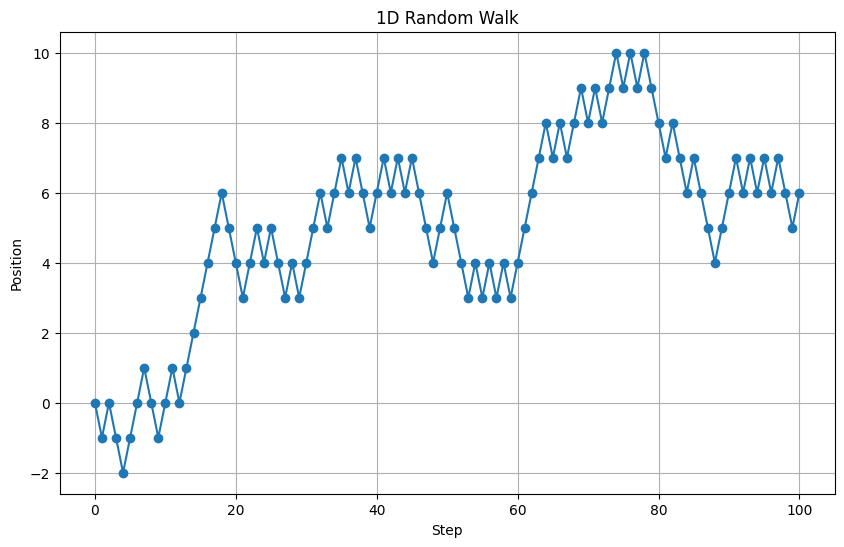

Final position after 100 steps: 6


In [39]:
import numpy as np
import matplotlib.pyplot as plt

def random_walk_1d(n_steps):
    # Generate random steps: -1 for a step to the left, 1 for a step to the right
    steps = np.random.choice([-1, 1], size=n_steps)
    
    # Compute the position after each step
    position = np.cumsum(steps)
    
    # Insert the starting point (0) at the beginning of the position array
    position = np.insert(position, 0, 0)
    
    return position

def plot_random_walk(position):
    plt.figure(figsize=(10, 6))
    plt.plot(position, marker='o')
    plt.title("1D Random Walk")
    plt.xlabel("Step")
    plt.ylabel("Position")
    plt.grid(True)
    plt.show()

# Parameters
n_steps = 100  # Number of steps in the random walk

# Simulate random walk
position = random_walk_1d(n_steps)

# Plot the random walk
plot_random_walk(position)

# Print the final position
print(f"Final position after {n_steps} steps: {position[-1]}")

Standard deviation of final positions after 100 steps with step size 3: 28.45


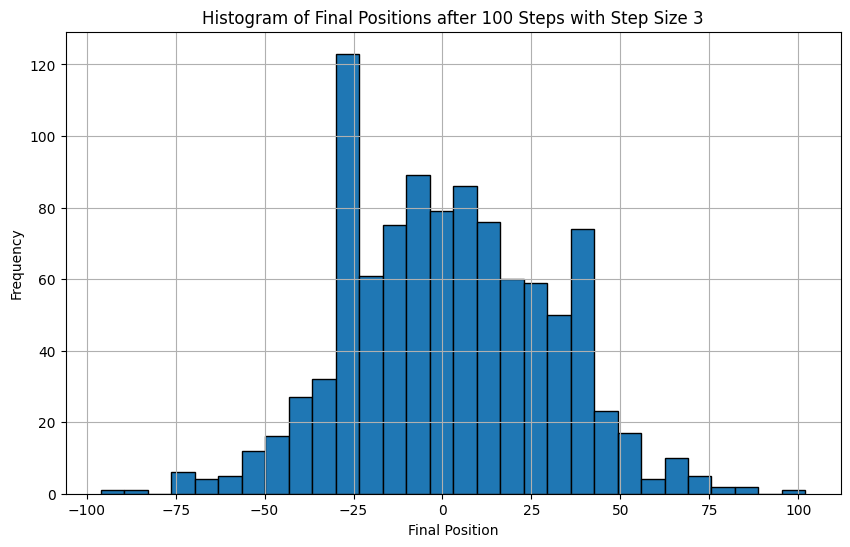

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def random_walk_1d_custom_step(n_steps, n_simulations, step_size):
    final_positions = []
    
    for _ in range(n_simulations):
        # Generate random steps: -step_size for a step to the left, step_size for a step to the right
        steps = np.random.choice([-step_size, step_size], size=n_steps)
        
        # Compute the final position
        final_position = np.sum(steps)
        
        final_positions.append(final_position)
    
    return final_positions

# Parameters
n_steps = 100  # Number of steps in each random walk
n_simulations = 1000  # Number of simulations to run
step_size = 3  # Step size

# Simulate random walks
final_positions = random_walk_1d_custom_step(n_steps, n_simulations, step_size)

# Compute standard deviation of final positions
std_dev_final_position = np.std(final_positions)
print(f"Standard deviation of final positions after {n_steps} steps with step size {step_size}: {std_dev_final_position:.2f}")

# Plot histogram of final positions
plt.figure(figsize=(10, 6))
plt.hist(final_positions, bins=30, edgecolor='black')
plt.title(f"Histogram of Final Positions after {n_steps} Steps with Step Size {step_size}")
plt.xlabel("Final Position")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
